#### Travail C

In [75]:
import pandas as pd 
from sklearn.cluster import KMeans
import numpy as np 
from sklearn import preprocessing
import math
import collections
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
from matplotlib.pyplot import matshow
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

> Chargement des données

In [6]:
path_bank = './bank-data.csv'
df_bank = pd.read_csv(path_bank)
df_bank.drop('id', axis=1, inplace=True)
df_bank.head(2)

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO


> Scikit-learn ne gère pas les données nominales, il faut les transformer. <br>
Un premier mapping est utilisé pour que toutes les colonnes aient le type int.

In [7]:
mappings = {}
categorical_columns = [c for i, c in enumerate(df_bank.columns) if df_bank.dtypes[i] == object]
for i, c in enumerate(df_bank.columns):
    if df_bank.dtypes[i] == object:
        for j, x in enumerate(np.unique(df_bank[c])):
            mappings[x] = j
mappings

{'FEMALE': 0,
 'MALE': 1,
 'INNER_CITY': 0,
 'RURAL': 1,
 'SUBURBAN': 2,
 'TOWN': 3,
 'NO': 0,
 'YES': 1}

In [8]:
df_bank[categorical_columns] = df_bank[categorical_columns].transform(lambda x: x.apply(lambda c: mappings[c]))
df_bank.head(2)

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,0,0,17546.0,0,1,0,0,0,0,1
1,40,1,3,30085.1,1,3,1,0,1,1,0


In [9]:
X, y = df_bank[df_bank.columns[:-1]], df_bank[df_bank.columns[-1]]

> Preprocessing: les données sont normalisées avant calcul des clusters, pour que les distances intra-features soient similaires

In [10]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

array([[ 0.38888715, -1.        , -0.95846483, ..., -1.49191369,
        -1.77142063, -0.73111343],
       [-0.16617033,  1.        ,  1.37609091, ..., -1.49191369,
         0.56451866,  1.36777681],
       [ 0.59703371, -1.        , -0.95846483, ...,  0.67028006,
         0.56451866, -0.73111343],
       ...,
       [-0.79061001, -1.        ,  1.37609091, ...,  0.67028006,
        -1.77142063, -0.73111343],
       [-0.92937438,  1.        , -0.95846483, ...,  0.67028006,
        -1.77142063,  1.36777681],
       [-0.30493471,  1.        ,  1.37609091, ..., -1.49191369,
         0.56451866,  1.36777681]])

> Application de la méthode de clustering

In [16]:
simple_kmeans = KMeans(n_clusters=6, init='random', n_init='auto').fit(X)
centroids = simple_kmeans.cluster_centers_
clusters = simple_kmeans.labels_
cluster_counter = collections.Counter(clusters)

Counter({4: 149, 1: 132, 0: 125, 3: 88, 2: 59, 5: 47})

> Pour réduire le nombre de clusters, on va calculer les distances inter-clusters, avec pour représentants les centroids.

In [12]:
def L2_distance(x,y):
    return math.sqrt(sum((a-b)**2 for a,b in zip(x,y)))
distance_matrix = [[L2_distance(x,y) for x in centroids] for y in centroids]

[[0.0,
  19080.218956408033,
  10106.316023647145,
  42476.0884262751,
  27479.588420566564,
  34925.56129848882],
 [19080.218956408033,
  0.0,
  8973.902976955234,
  23395.869964019224,
  8399.369508251904,
  15845.342404060348],
 [10106.316023647145,
  8973.902976955234,
  0.0,
  32369.77273631304,
  17373.272410633355,
  24819.24536447036],
 [42476.0884262751,
  23395.869964019224,
  32369.77273631304,
  0.0,
  14996.501623578188,
  7550.528445634105],
 [27479.588420566564,
  8399.369508251904,
  17373.272410633355,
  14996.501623578188,
  0.0,
  7445.973380565248],
 [34925.56129848882,
  15845.342404060348,
  24819.24536447036,
  7550.528445634105,
  7445.973380565248,
  0.0]]

> Ensuite, on connecte les clusters qui ont une distance inférieure à 10.000. <br>
> Le problème devient un problème de graphe. <br>
> J'utilise ici une méthode générale pour trouver les composantes connectées d'un graphe: la structure de données Union Find. <br>
> Bien entendu comme on n'a que 6 clusters on aurait pu se contenter de regarder la matrice de distance, mais la méthode que j'utlise s'applique à un nombre arbitraire de clusters. <br>
> J'utilise les optimisations union by rank et path compression.

In [59]:
class UnionFind():
    def __init__(self, size):
        self.size = size 
        self.root = [i for i in range(self.size)]
        self.rank = [1 for _ in range(self.size)]

    def find(self, x):
        if x != self.root[x]:
            self.root[x] = self.find(self.root[x])
        return self.root[x]
    
    def union(self, x, y):
        root_x, root_y = self.root[x], self.root[y]
        if root_x != root_y: 
            if self.rank[root_x] > self.rank[root_y]:
                self.root[root_y] = self.root[root_x]
            elif self.rank[root_y] < self.rank[root_x]:
                self.root[root_x] = self.root[root_y]
            else:
                self.rank[root_x] += 1 
                self.root[root_y] = self.root[root_x]
    
    def is_connected(self, x, y):
        return self.find(x) == self.find(y)
    
    def get_clusters(self):
        clusters = collections.defaultdict(list)
        for i in range(self.size):
            self.find(i)
        for i, r in enumerate(self.root):
            clusters[r].append(i)
        return clusters

UF = UnionFind(6)
for i in range(6):
    for j in range(i+1, 6):
        if distance_matrix[i][j] <= 10000:
            UF.union(i,j)

new_clusters = UF.get_clusters()

defaultdict(list, {0: [0], 1: [1, 2, 3, 4, 5]})

> On voit que la méthode avec la matrice de distance ne semble pas fonctionner. <br>
> On a émis l'hypothèse d'une transitivité de la connection entre clusters, cependant elle est probablement fausse. <br> 
> A peut etre proche de B et B proche de C sans que A soit proche de C.

> On peut afficher la matrice de distance pour expliquer le phénomène.

In [60]:
distance_np_matrix = np.asarray(distance_matrix)
distance_np_matrix *= -1

array([[    -0.        , -19080.21895641, -10106.31602365,
        -42476.08842628, -27479.58842057, -34925.56129849],
       [-19080.21895641,     -0.        ,  -8973.90297696,
        -23395.86996402,  -8399.36950825, -15845.34240406],
       [-10106.31602365,  -8973.90297696,     -0.        ,
        -32369.77273631, -17373.27241063, -24819.24536447],
       [-42476.08842628, -23395.86996402, -32369.77273631,
            -0.        , -14996.50162358,  -7550.52844563],
       [-27479.58842057,  -8399.36950825, -17373.27241063,
        -14996.50162358,     -0.        ,  -7445.97338057],
       [-34925.56129849, -15845.34240406, -24819.24536447,
         -7550.52844563,  -7445.97338057,     -0.        ]])

([<matplotlib.axis.YTick at 0x7fc93aefa950>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6')])

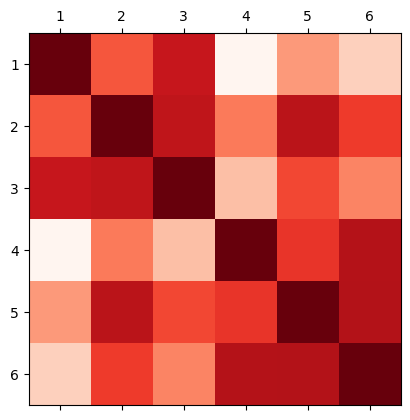

In [63]:
matshow(distance_np_matrix, cmap='Reds')
plt.xticks(np.arange(6), np.arange(1, 7))
plt.yticks(np.arange(6), np.arange(1, 7))

> Voici ce quelques informations qu'on peut extraire de la matrice de distances: <br>
>> ligne 1: {1,3} <br>
>> ligne 2: {2,5}, {2,3} <br>
>> ligne 3: {3,1}, {3,2} <br>
>> ligne 4: {4,6}, {4,5} <br>
>> ligne 5: {5,6}, {5,2} <br>
>> ligne 6: {6,5}, {6,4} <br>

Cela donne par transitivité:
> {1,3,2,5,4,6}

> On peut tenter de limiter au cluster le plus proche pour voir si cela règle le problème.

In [64]:
for i in range(6): distance_np_matrix[i,i] = -math.inf
UF = UnionFind(6)
for i in range(5):
    UF.union(i, np.argmax(distance_np_matrix[i,:]))

In [65]:
new_clusters = UF.get_clusters()

defaultdict(list, {0: [0, 1, 2, 3, 4, 5]})

> On obtient de nouveau un seul cluster !
> Il semble que la distance euclidienne sur les données normalisées ne permette pas de bien regrouper les clusters...

> Limitation à 3 clusters

In [67]:
simple_kmeans_2 = KMeans(n_clusters=3, init='random', n_init='auto').fit(X)
centroids = simple_kmeans_2.cluster_centers_
clusters = simple_kmeans_2.labels_
cluster_counter = collections.Counter(clusters)

Counter({1: 273, 0: 221, 2: 106})

> En observant les nombres d'éléments dans les clusters, il semble que les nouveaux cluster corerspondent à:
>> 3': 3+6 <br>
>> 1': 2+4 <br>
>> 2': 1+5 <br>

> Ces associations ne correspondent pas aux centroids les plus proches deux à deux pour la distance euclidienne sur les données normalisées ! <br>
> Il faudrait peut-être calculer la distance inter-clusters avec les médoids.

> Suite <br>

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
kmeans = KMeans(n_clusters=2, random_state=0, init='random', n_init='auto').fit(X_train)

KMeans(init='random', n_clusters=2, n_init='auto', random_state=0)

> Je reprends les mêmes fonctions que pour DBScan même si ici il n'y pas de d'instances non classifiées.

In [87]:
def get_global_accuracy(y_true, y_pred):
    """ 
    Get accuracy by considering that an instance without cluster is wrongly classified
    """
    return max(sum(x == y for x,y in zip(y_true, y_pred) if y in [0,1]), sum(x != y for x,y in zip(y_true, y_pred) if y in [0,1])) / len(y_pred)

In [88]:
train_acc = get_global_accuracy(y_train, kmeans.labels_)
labels_true_pred = [(t,p)for t,p in zip(y_train, kmeans.labels_) if p != -1]
cm = confusion_matrix([x[0] for x in labels_true_pred], [abs(x[1]-1) for x in labels_true_pred])
print(f'train accuracy: {train_acc}\nconfusion matrix: \n{cm}')
print(f'Number not classified: {sum(x == -1 for x in kmeans.labels_)}')

train accuracy: 0.587037037037037
confusion matrix: 
[[219  72]
 [151  98]]
Number not classified: 0


In [89]:
y_pred_test = kmeans.predict(X_test)
test_acc = get_global_accuracy(y_test, y_pred_test)
labels_true_pred = [(t,p)for t,p in zip(y_test, y_pred_test) if p != -1]
cm = confusion_matrix([x[0] for x in labels_true_pred], [abs(x[1]-1) for x in labels_true_pred])
print(f'test accuracy: {test_acc}\nconfusion matrix: \n{cm}')
print(f'Number not classified: {sum(x == -1 for x in kmeans.labels_)}')

test accuracy: 0.6666666666666666
confusion matrix: 
[[28  7]
 [13 12]]
Number not classified: 0


> Utilisation de l'initialisation kmeans++ (farthest first améliorée)

In [93]:
kmeans_pplus = KMeans(n_clusters=2, random_state=0, init='k-means++', n_init='auto').fit(X_train)

train_acc = get_global_accuracy(y_train, kmeans_pplus.labels_)
labels_true_pred = [(t,p)for t,p in zip(y_train, kmeans_pplus.labels_) if p != -1]
cm = confusion_matrix([x[0] for x in labels_true_pred], [abs(x[1]-1) for x in labels_true_pred])
print(f'train accuracy: {train_acc}\nconfusion matrix: \n{cm}')
print(f'Number not classified: {sum(x == -1 for x in kmeans_pplus.labels_)}')

y_pred_test = kmeans_pplus.predict(X_test)
test_acc = get_global_accuracy(y_test, y_pred_test)
labels_true_pred = [(t,p)for t,p in zip(y_test, y_pred_test) if p != -1]
cm = confusion_matrix([x[0] for x in labels_true_pred], [abs(x[1]-1) for x in labels_true_pred])
print(f'test accuracy: {test_acc}\nconfusion matrix: \n{cm}')
print(f'Number not classified: {sum(x == -1 for x in kmeans_pplus.labels_)}')

train accuracy: 0.5851851851851851
confusion matrix: 
[[ 72 219]
 [ 97 152]]
Number not classified: 0
test accuracy: 0.6666666666666666
confusion matrix: 
[[ 7 28]
 [12 13]]
Number not classified: 0


> Les accuracy sont les mêmes, les matrices de confusion ont changé.